# T8 - Tips and tricks

This tutorial contains suggestions that aren't essential to follow, but which may make your life easier.

## Versioning

Covasim contains a number of built-in tools to make it easier to keep track of where results came from. The simplest of these is that if you save an image using `cv.savefig()` instead of `pl.savefig()`, it will automatically store information about the script and Covasim version that generated it:

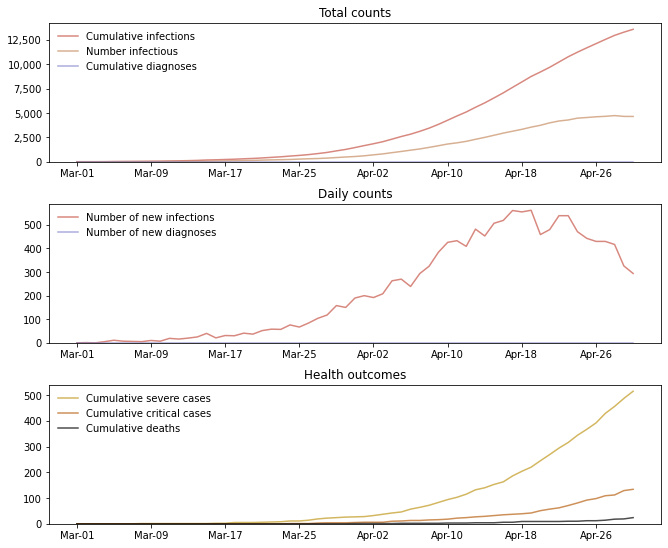

In [28]:
import covasim as cv
import matplotlib.pyplot as plt
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

sim = cv.Sim()
sim.run()

%matplotlib inline
sim.plot()

In [29]:
filename = "my-figure.png"
cv.savefig(filename, bbox_inches='tight') # Save including version information
plt.show()
cv.get_png_metadata(filename) # Retrieve and print information


<Figure size 432x288 with 0 Axes>

Covasim version: 2.0.2
Covasim branch: master
Covasim hash: 5f7cf50
Covasim date: 2021-03-12 21:31:25 UTC
Covasim caller branch: master
Covasim caller hash: 5f7cf50
Covasim caller date: 2021-03-12 21:31:25 UTC
Covasim caller filename: /Users/sophieayling/Documents/GitHub/covasim/covasim/misc.py
Covasim current time: 2021-Mar-13 16:23:47
Covasim calling file: <ipython-input-29-0ad70a28f76d>, line 2


This can be extremely useful for figuring out where that intriguing result you generated 3 weeks ago came from!

This information is also stored in sims and multisims themselves:

In [6]:
print(sim.version)
print(sim.git_info)

2.0.2
{'covasim': {'version': '2.0.2', 'branch': 'master', 'hash': '01046e6', 'date': 'Date N/A'}, 'called_by': {'branch': 'master', 'hash': '01046e6', 'date': 'Date N/A', 'filename': '/Users/sophieayling/Documents/GitHub/covasim/covasim/base.py'}}


Finally, the function `cv.check_version()` and `cv.check_save_version()` are useful if you want to ensure that users are running the right version of your code. Placing `cv.check_save_version('2.0.0')` will save a file with the information above to the current folder – again, useful for debugging exactly what changed and when. (You can also provide additional information to it, e.g. to also save the versions of 3rd-party packages you're importing). `cv.check_version()` by itself can be used to provide a warning or even raise an exception (if `die=True`) if the version is not what's expected:

In [7]:
cv.check_version('1.5.0')

Note: Covasim is newer than expected (2.0.2 vs. 1.5.0)


1

## Working with dates

Dates can be tricky to work with. Covasim comes with a number of built-in features to work with dates. By default, by convention Covasim works with dates in the format `YYYY-MM-DD`, e.g. `'2020-12-01'`. However, it can handle a wide variety of other date and `datetime` objects. In particular, `sim` objects know when they start and end, and can use this to do quite a bit of date math:

In [8]:
sim = cv.Sim(start_day='20201122', end_day='2020-12-09 02:14:58.727703')
sim.initialize() # Date conversion happens on initialization
print(sim['start_day'])
print(sim['end_day'])
print(sim.day(sim['end_day'])) # Prints the number of days until the end day, i.e. the length of the sim

2020-11-22
2020-12-09
17


You can also easily calculate the difference between two dates, or generate a range of dates. These are returned as strings by default, but can be converted to datetime objects via Sciris:

In [9]:
import sciris as sc

print(cv.daydiff('2020-06-01', '2020-07-01', '2020-08-01'))
dates = cv.date_range('2020-04-04', '2020-04-12')
print(dates)
print(sc.readdate(dates))

[30, 31]
['1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01']
1970-01-01 00:00:00


Finally, one gotcha is that when loading Excel spreadsheets in pandas, dates are loaded in pandas' internal `Timestamp[ns64]` format, which nothing else seems to be able to read. If this happens to you, the solution (as far as Covasim is concerned) is to convert to a `datetime.date`:

```python
data = pd.read_excel(filename)
data['date'] = data['date'].dt.date
```

## Working with dictionaries

"I already know how to work with dictionaries", you say. Yes, you do. But there are a couple tricks that might make things easier.

Covasim is built on Sciris, which includes containers `odict` and `objdict`. While these are [documented elsewhere](https://sciris.readthedocs.io/en/latest/_autosummary/sciris.sc_odict.odict.html#sciris.sc_odict.odict), a couple examples will serve to illustrate how they work.

An `odict` is just an ordered dict that you can refer to by *position* as well as by key. For example:

In [10]:
mydict = sc.odict(foo=[1,2,3], bar=[4,5,6]) # Assignment is the same as ordinary dictionaries
print('Entry foo:', mydict['foo'])
print('Entry 0:',    mydict[0]) # Access by key or by index
for i,key,value in mydict.enumitems(): # Additional methods for iteration
    print(f'Item {i} is named {key} and has value {value}')

Entry foo: [1, 2, 3]
Entry 0: [1, 2, 3]
Item 0 is named foo and has value [1, 2, 3]
Item 1 is named bar and has value [4, 5, 6]


An `objdict` is exactly the same as an odict except it lets you reference keys as if they were attributes:

In [12]:
myobjdict = sc.objdict(foo=[1,2,3], bar=[4,5,6])
print('Entry foo:', myobjdict['foo'])
print('Entry 0:',    myobjdict[0]) # Access by key or by index
print('"Attribute" foo:', myobjdict.foo)

Entry foo: [1, 2, 3]
Entry 0: [1, 2, 3]
"Attribute" foo: [1, 2, 3]


Using this approach, you can get all the power and flexibility of dictionaries, while writing code as succinctly as possible. For example:

In [13]:
total_pop = 44_483 # This many total people

pars= sc.objdict(
    pop_type = 'hybrid',
    pop_size = 10e3,
)
pars.pop_scale = total_pop/pars.pop_size # Instead of pars['pop_scale'] = total_pop/pars['pop_size'] 
sim = cv.Sim(**pars) # It's still a dict, so you can treat it as one!

Finally, Sciris also contains a function called `mergedicts`. This acts very similarly to `dict.update()`, with the main difference being that it returns the result of merging the two dictionaries. This is especially useful for handling keyword arguments in functions:

In [14]:
def myfunc(args=None, **kwargs):
    defaults = dict(foo=[1,2,3], bar=[4,5,6])
    merged_args = sc.mergedicts(defaults, args, kwargs)
    print(merged_args)

myfunc(args=dict(bar=18), other_args='can be anything')

{'foo': [1, 2, 3], 'bar': 18, 'other_args': 'can be anything'}


As you can see, it merged the default settings, the arguments supplied to the function via the keyword `args`, and then other keywords, into a single dictionary.